In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "BES1"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn025631,MMSFYLSSVKDNQRYYVEREKGCKPTLAEIGGTSTNITPCSSQNPS...,248,1
1,Achn038411,MTSLSVSQSRVRPPPVVPIGGLRSSKTTNRFHERFPDSLLNFEINE...,355,1
2,Achn072001,MTTEMQRFGTSEEDDEDMGMDVKEEDDDDDDDDDEKNNGTPIMVGV...,744,1
3,Achn103731,MASGTRLPSWKERENNKRRERRRRAIAAKIYTGLRMYGNYKLPKHC...,345,1
4,Achn131841,MWEGESDAAATTGGGGRRKPSWRERENNRRRERRRRAVAAKIYSGL...,310,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
386,0.014815,0.0,0.004444,0.002963,0.004444,0.008889,0.001481,0.002963,0.004444,0.007407,...,0.002963,0.002963,0.000000,0.004444,0.001481,0.001481,0.004444,0.001481,0.0,0.001481
2297,0.000000,0.0,0.000000,0.009479,0.004739,0.000000,0.000000,0.004739,0.000000,0.009479,...,0.000000,0.004739,0.000000,0.004739,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
588,0.003717,0.0,0.003717,0.000000,0.000000,0.011152,0.003717,0.003717,0.007435,0.003717,...,0.003717,0.000000,0.003717,0.003717,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
394,0.006410,0.0,0.000000,0.000000,0.000000,0.003205,0.000000,0.006410,0.006410,0.003205,...,0.003205,0.003205,0.003205,0.003205,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2756,0.003322,0.0,0.000000,0.000000,0.009967,0.000000,0.003322,0.006645,0.003322,0.009967,...,0.003322,0.000000,0.000000,0.000000,0.003322,0.000000,0.000000,0.000000,0.0,0.006645


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2459, 441)
X_test: (615, 441)
y_train: (2459,)
y_test: (615,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 18s 627ms/step - accuracy: 0.6250 - loss: 0.6926

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6905 - loss: 0.6797   

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6982 - loss: 0.6767 - val_accuracy: 0.9065 - val_loss: 0.5024


Epoch 2/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8594 - loss: 0.5376

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9131 - loss: 0.3675 - val_accuracy: 0.9817 - val_loss: 0.0643


Epoch 3/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0538

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0438 - val_accuracy: 0.9898 - val_loss: 0.0350


Epoch 4/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0336

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0311 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.0305 - val_accuracy: 0.9939 - val_loss: 0.0269


Epoch 5/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0215

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0177 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0176 - val_accuracy: 0.9919 - val_loss: 0.0320


Epoch 6/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0026

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0118 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0123 - val_accuracy: 0.9919 - val_loss: 0.0395


Epoch 7/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0301

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0163 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0158 - val_accuracy: 0.9939 - val_loss: 0.0268


Epoch 8/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0029

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0067 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0069 - val_accuracy: 0.9919 - val_loss: 0.0259


Epoch 9/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.3626e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0047     

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9939 - val_loss: 0.0363


Epoch 10/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0038

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0060 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0061 - val_accuracy: 0.9898 - val_loss: 0.0279


Epoch 11/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0025

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0024 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9939 - val_loss: 0.0386


Epoch 12/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.8816e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0039     

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0036 - val_accuracy: 0.9939 - val_loss: 0.0385


Epoch 13/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.4735e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0019     

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0018 - val_accuracy: 0.9939 - val_loss: 0.0360


Epoch 14/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0012

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0016 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9878 - val_loss: 0.0372



[Train Accuracy: 99.90% - Test Accuracy: 98.37%]


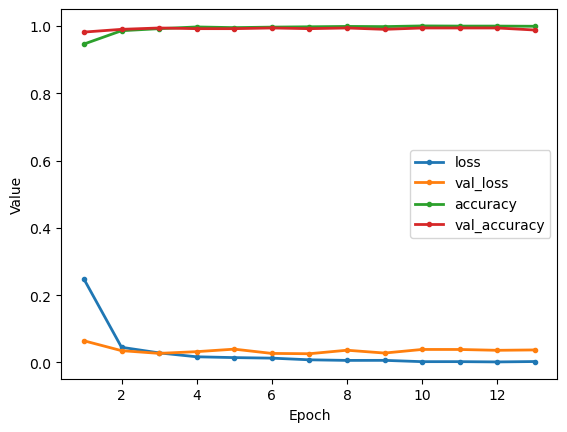

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
386,0.002967,0.0,0.0,0.001484,0.001484,0.001484,0.0,0.0,0.000000,0.002967,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003731,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003215,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2756,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.003333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2459, 8672)
X_test: (615, 8672)
y_train: (2459,)
y_test: (615,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,220,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,553 (8.63 MB)

 Trainable params: 2,263,553 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 19s 647ms/step - accuracy: 0.5000 - loss: 0.6931

 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5244 - loss: 0.6925   

15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5823 - loss: 0.6902

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6397 - loss: 0.6848

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6819 - loss: 0.6746

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6861 - loss: 0.6732 - val_accuracy: 0.9858 - val_loss: 0.4187


Epoch 2/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.4221

 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9769 - loss: 0.3718 

16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9782 - loss: 0.3184

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9806 - loss: 0.2753

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9825 - loss: 0.2433 - val_accuracy: 0.9980 - val_loss: 0.0135


Epoch 3/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0191

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0132 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0110

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0100

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0063


Epoch 4/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0034

 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020 

16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0040


Epoch 5/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0013

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0031


Epoch 6/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.2702e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4328e-04 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0332e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6113e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.6675e-04 - val_accuracy: 1.0000 - val_loss: 0.0026


Epoch 7/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.2845e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7124e-04 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3894e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7565e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.8628e-04 - val_accuracy: 1.0000 - val_loss: 0.0024


Epoch 8/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.6191e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9831e-04 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0082e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1188e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1885e-04 - val_accuracy: 1.0000 - val_loss: 0.0023


Epoch 9/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.1155e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3387e-04 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1933e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1853e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2049e-04 - val_accuracy: 1.0000 - val_loss: 0.0022


Epoch 10/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.9022e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7782e-04 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2552e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4091e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4044e-04 - val_accuracy: 1.0000 - val_loss: 0.0017


Epoch 11/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.6444e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9625e-05 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8170e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9031e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2770e-05 - val_accuracy: 0.9980 - val_loss: 0.0021


Epoch 12/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.4336e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7323e-05 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1184e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4106e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4269e-05 - val_accuracy: 0.9980 - val_loss: 0.0021


Epoch 13/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.2309e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4696e-05 

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4993e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4879e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5768e-05 - val_accuracy: 0.9980 - val_loss: 0.0025



[Train Accuracy: 100.00% - Test Accuracy: 99.35%]


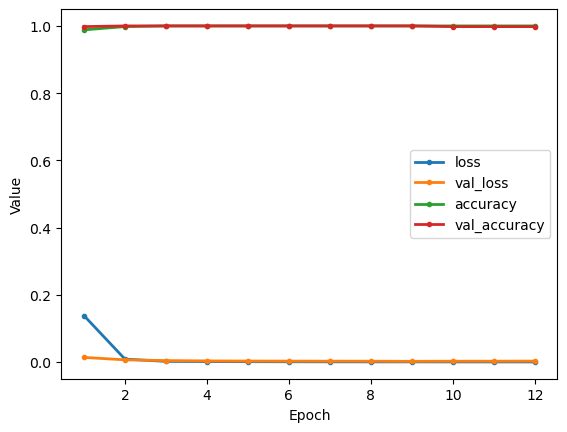

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
386,0.001486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2756,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      32,712,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,754,177 (124.95 MB)

 Trainable params: 32,754,177 (124.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 25s 860ms/step - accuracy: 0.4375 - loss: 0.6932

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4258 - loss: 0.6933  

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4349 - loss: 0.6933

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.4375 - loss: 0.6933

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4444 - loss: 0.6932

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4497 - loss: 0.6931

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4563 - loss: 0.6930

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4608 - loss: 0.6929

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4657 - loss: 0.6928

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4704 - loss: 0.6926

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4741 - loss: 0.6924

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4772 - loss: 0.6923

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4794 - loss: 0.6921

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4814 - loss: 0.6919

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4834 - loss: 0.6918

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4857 - loss: 0.6915

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4887 - loss: 0.6913

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4924 - loss: 0.6911

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4968 - loss: 0.6908

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5016 - loss: 0.6905

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5066 - loss: 0.6902

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5119 - loss: 0.6898

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5173 - loss: 0.6895

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5230 - loss: 0.6891

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5287 - loss: 0.6886

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5345 - loss: 0.6881

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5402 - loss: 0.6877

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5460 - loss: 0.6871

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5517 - loss: 0.6865

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5573 - loss: 0.6859

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5628 - loss: 0.6852

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5679 - loss: 0.6846 - val_accuracy: 0.9959 - val_loss: 0.5671


Epoch 2/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.5619

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.5588 

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.5520

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.5477

 5/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.5438

 6/31 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.5392

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.5352

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.5312

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.5271

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.5226

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.5182

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.5142

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.5101

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.5061

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.5018

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.4975

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.4931

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.4886

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.4841

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.4796

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.4750

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.4705

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.4660

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.4615

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.4570

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.4525

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.4481

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.4437

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9998 - loss: 0.4393

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9998 - loss: 0.4350

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9997 - loss: 0.4307

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9997 - loss: 0.4267 - val_accuracy: 0.9858 - val_loss: 0.0716


Epoch 3/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9844 - loss: 0.0607

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9883 - loss: 0.0564 

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9887 - loss: 0.0581

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9896 - loss: 0.0573

 5/31 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9904 - loss: 0.0562

 6/31 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9911 - loss: 0.0549

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9918 - loss: 0.0536

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9923 - loss: 0.0522

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9928 - loss: 0.0510

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9932 - loss: 0.0497

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9936 - loss: 0.0485

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9939 - loss: 0.0473

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9942 - loss: 0.0461

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9944 - loss: 0.0451

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9946 - loss: 0.0440

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9949 - loss: 0.0430

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9951 - loss: 0.0421

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9952 - loss: 0.0412

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9954 - loss: 0.0404

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9956 - loss: 0.0396

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9957 - loss: 0.0389

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9958 - loss: 0.0383

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9959 - loss: 0.0377

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9959 - loss: 0.0371

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9960 - loss: 0.0365

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9960 - loss: 0.0360

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9961 - loss: 0.0355

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9962 - loss: 0.0350

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9962 - loss: 0.0345

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9963 - loss: 0.0340

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9963 - loss: 0.0336

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9964 - loss: 0.0332 - val_accuracy: 0.9959 - val_loss: 0.0143


Epoch 4/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0038

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0045 

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 0.0046

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0051

 5/31 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0053

 6/31 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0052

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0051

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0051

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0050

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0049

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0048

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0047

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0046

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0045

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0044

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0044

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0043

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0043

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0043

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.0043

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.0043

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 0.0042

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9998 - loss: 0.0042

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9998 - loss: 0.0042

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9998 - loss: 0.0042

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9998 - loss: 0.0042

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9998 - loss: 0.0041

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9998 - loss: 0.0041

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0041

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0041

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9997 - loss: 0.0041

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9997 - loss: 0.0040 - val_accuracy: 0.9959 - val_loss: 0.0099


Epoch 5/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0019

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0017 

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0016

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0015

 5/31 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0014

 6/31 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 0.0014

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0014

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0013

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0013

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0013

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0013

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0012

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0012

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0012

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0012

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0012

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0012

18/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0012

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0012

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0012

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0012

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0012

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0012

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9959 - val_loss: 0.0127


Epoch 6/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 6.0572e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 6.1197e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 5.7532e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 5.4926e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 5.4414e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 5.3872e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 5.3118e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 5.2587e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.2388e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.2130e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.1810e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.1432e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.1022e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.0640e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.0295e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.0152e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.0103e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 5.0069e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 5.0025e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.0020e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.0028e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.9983e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.1259e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.2325e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.3253e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.4058e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.4743e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.5333e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.5838e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.6287e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.6679e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 1.0000 - loss: 5.7047e-04 - val_accuracy: 0.9959 - val_loss: 0.0092


Epoch 7/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 1.0000 - loss: 3.6977e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 4.1793e-04 

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 4.2718e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 4.2124e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 4.1627e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.1745e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.1649e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.1466e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.1304e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.8513e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 5.3708e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 5.7442e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.0282e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.2354e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.3835e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.4879e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.5646e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 6.6128e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6424e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6589e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6626e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6787e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6851e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6870e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6804e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6674e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6486e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6275e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.6017e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 6.5739e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.5505e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 6.5285e-04 - val_accuracy: 0.9939 - val_loss: 0.0171


Epoch 8/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 1.6723e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.0199e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.4860e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.8203e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.9776e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.0532e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.1744e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.2601e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.2982e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.3104e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.3168e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.3071e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.2893e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.2683e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.2416e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.2103e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.1850e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.1652e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.1430e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.1203e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.0993e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.0794e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.0603e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.0413e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.0220e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.0032e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.9841e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.9648e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.9457e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.9264e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.9075e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 2.8898e-04 - val_accuracy: 0.9959 - val_loss: 0.0132


Epoch 9/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 1.0000 - loss: 4.5604e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.7466e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 3.2626e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 2.9944e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8184e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.0295e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1298e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1789e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1991e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1913e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1768e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1583e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1349e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1122e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.0844e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.0537e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.0219e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9889e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9556e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.9258e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8969e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8686e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8406e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8127e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.7861e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.7598e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.7352e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.7118e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6890e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6674e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6473e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 2.6284e-04 - val_accuracy: 0.9959 - val_loss: 0.0114


Epoch 10/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 2.1261e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 2.2135e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.1062e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.9918e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9386e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.8851e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.8494e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.8169e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7851e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.7585e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7300e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7233e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7172e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7103e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7001e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6906e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.6822e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6732e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6717e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6688e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6652e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6619e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6587e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6551e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6512e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6483e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6444e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6415e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6383e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6342e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.6302e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 1.6265e-04 - val_accuracy: 0.9959 - val_loss: 0.0123


Epoch 11/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 6.0808e-05

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 5.6741e-05

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 7.1032e-05

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 7.8132e-05

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.1599e-05

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.3695e-05

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.5465e-05

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.7835e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.9565e-05

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.0538e-05

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.1427e-05

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.1987e-05

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.2507e-05

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.2971e-05

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.3492e-05

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.3784e-05

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.3897e-05

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4026e-05

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4081e-05

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4138e-05

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4223e-05

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4277e-05

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4198e-05

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4044e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.3834e-05

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.3583e-05

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.3350e-05

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.3111e-05

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.3041e-05

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.2966e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.2886e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 9.2811e-05 - val_accuracy: 0.9959 - val_loss: 0.0141



[Train Accuracy: 100.00% - Test Accuracy: 99.19%]


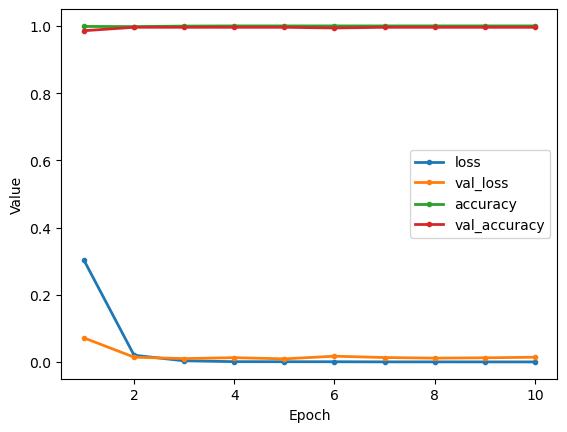

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
report.save()

Report saved as Output/Reports/BES1/report_NUKYJOPF.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################